In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import math
import tensorflow as tf
import numpy as np

from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory
import eval_image_classifier
import matplotlib.pyplot as plt

W1030 09:11:36.394522 140058166028096 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1030 09:11:37.002462 140058166028096 module_wrapper.py:139] From /home/psturm/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W1030 09:11:37.008357 140058166028096 module_wrapper.py:139] From /home/psturm/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [3]:
import json
import shap
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

In [4]:
tf.app.flags.DEFINE_string('f', None, '')
import eval_image_classifier
slim = tf.contrib.slim
FLAGS = tf.app.flags.FLAGS
FLAGS.batch_size = 501
FLAGS.dataset_name = 'imagenet'
FLAGS.dataset_split_name = 'train'
FLAGS.dataset_dir = '/data/image_datasets/imagenet/'
FLAGS.eval_image_size = 299
FLAGS.model_name = 'inception_v4'
FLAGS.checkpoint_path = 'inception_v4.ckpt'

In [5]:
tf.logging.set_verbosity(tf.logging.ERROR)
tf_global_step = slim.get_or_create_global_step()

######################
# Select the dataset #
######################
dataset = dataset_factory.get_dataset(
    FLAGS.dataset_name, FLAGS.dataset_split_name, FLAGS.dataset_dir)

##############################################################
# Create a dataset provider that loads data from the dataset #
##############################################################
provider = slim.dataset_data_provider.DatasetDataProvider(
    dataset,
    shuffle=False,
    common_queue_capacity=2 * FLAGS.batch_size,
    common_queue_min=FLAGS.batch_size)
[image, label] = provider.get(['image', 'label'])
label -= FLAGS.labels_offset

#####################################
# Select the preprocessing function #
#####################################
preprocessing_name = FLAGS.preprocessing_name or FLAGS.model_name
image_preprocessing_fn = preprocessing_factory.get_preprocessing(
    preprocessing_name,
    is_training=False)

eval_image_size = FLAGS.eval_image_size

image = image_preprocessing_fn(image, eval_image_size, eval_image_size)

images, labels = tf.train.batch(
    [image, label],
    batch_size=FLAGS.batch_size,
    num_threads=FLAGS.num_preprocessing_threads,
    capacity=5 * FLAGS.batch_size)

In [6]:
tf.logging.set_verbosity(tf.logging.INFO)

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [8]:
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(coord=coord, sess=sess)

W1030 09:11:39.039385 140058166028096 deprecation.py:323] From <ipython-input-8-4c4d0928bd21>:2: start_queue_runners (from tensorflow.python.training.queue_runner_impl) is deprecated and will be removed in a future version.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.


In [9]:
def normalize(im_batch):
    max_vals = np.amax(im_batch, axis=(1,2,3), keepdims=True)
    min_vals = np.amin(im_batch, axis=(1,2,3), keepdims=True)
    return (im_batch - min_vals) / (max_vals - min_vals)

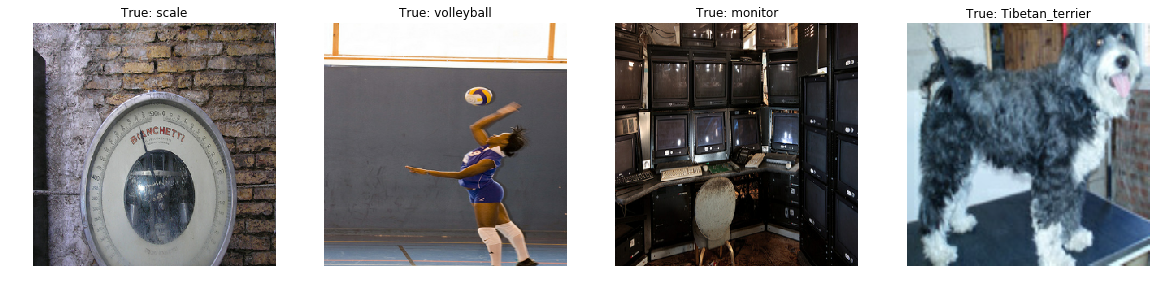

In [10]:
im_batch, label_batch = sess.run([images, labels])

norm_im_batch = normalize(im_batch)
true_names = np.vectorize(lambda x: class_names[str(x)][1])(label_batch - 1)

num_images = 4
fig, axs = plt.subplots(1, num_images, figsize=(20, 20*num_images))
for i in range(num_images):
    axs[i].imshow(norm_im_batch[i])
    axs[i].axis('off')
    axs[i].set_title('True: {}'.format(true_names[i]))

In [11]:
np.save('../data/ignored/reference_images.npy', im_batch)
np.save('../data/ignored/reference_labels.npy', label_batch)